# Regional Electricity Demand Data

{badge}`python3,badge-success` {badge}`exploratory data analysis,badge-secondary` {badge}`energy market,badge-warning` 

This post explores the 5-min regional electricity demand data from the Electricity Market of the Philippines.

## Setup

### Libraries

In [1]:
import glob
import pandas as pd
import os

### Functions

In [2]:
def concatenate_csv_local(file_dir, dest_dir, output_filename="output"):
    """
    Conatenates multiple hourly csv into one daily file. 
    """
    try:
        files = glob.glob(os.path.join(file_dir, "RTDREG_*.csv")) 
        
        date_columns = ['RUN_TIME','TIME_INTERVAL']
            
        df = pd.concat((pd.read_csv(f, header = 0, error_bad_lines=False, skipfooter=1, engine='python', parse_dates=date_columns) for f in files))
        df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
        df.to_csv(os.path.join(dest_dir, "Combined-{}.csv".format(output_filename)), index=False)
        print("Concatenate sucess: RTD-{}.csv".format(output_filename))
        
    except ValueError:
        print("File not found: {}".format(output_filename))

### DataFrame html format

In [3]:
t_props = [
  ('font-size', '80%')
  ]
   
styles = [
  dict(selector="th", props=t_props),
  dict(selector="td", props=t_props)
  ]

### Paths

In [4]:
dir = "/Volumes/data/projects/django-mms/data/demand_daily"

## The Regional Electricity Demand Dataset

This post uses regional electricity demand time series dataset from the Independent Electricity Market Operator of the Philippines (www.iemop.ph). 

The dataset contains several features such as 'Time Interval', 'Market Type', 'Region Name', 'Commodity Type', 'Market Requirment', 'Generation' and 'Losses' among others.

For simplicity we will only consider the following: 'Time Interval', 'Region Name' with corresponds to the three major subgrids, and 'Market Requirment' with is the electricity demand required for the current interval.

### Loading

In [5]:
concatenate_csv_local(dir,dir,"regional-demand")

Concatenate sucess: RTD-regional-demand.csv


In [44]:
filename = os.path.join(dir, "Combined-regional-demand" + "." + "csv")
df = pd.read_csv(filename)

### Inspection and Cleanup


In [45]:
df.head().style.set_table_styles(styles)

,RUN_TIME,MKT_TYPE,TIME_INTERVAL,REGION_NAME,COMMODITY_TYPE,MKT_REQT,LOAD_BID,LOAD_CURTAILED,LOSSES,GENERATION,MKT_IMPORT,MKT_EXPORT
0,2021-06-26 00:00:00,RTD,2021-06-26 00:05:00,CLUZ,Dr,500.000000,0,nan,0.000000,470.000000,0.000000,0.000000
1,2021-06-26 00:00:00,RTD,2021-06-26 00:05:00,CMIN,Dr,150.000000,0,nan,0.000000,125.000000,0.000000,0.000000
2,2021-06-26 00:00:00,RTD,2021-06-26 00:05:00,CVIS,Dr,138.000000,0,nan,0.000000,130.290000,0.000000,0.000000
3,2021-06-26 00:00:00,RTD,2021-06-26 00:05:00,CLUZ,En,7493.100000,320,0.000000,129.660000,7879.430000,63.330000,0.000000
4,2021-06-26 00:00:00,RTD,2021-06-26 00:05:00,CVIS,En,1476.130000,0,0.000000,20.040000,1559.500000,0.000000,63.330000


In [46]:
df.describe().style.set_table_styles(styles)

,MKT_REQT,LOAD_BID,LOAD_CURTAILED,LOSSES,GENERATION,MKT_IMPORT,MKT_EXPORT
count,213590.000000,213590.000000,43200.000000,213590.000000,213590.000000,213590.000000,213590.000000
mean,938.039390,10.136804,1.352876,15.088959,907.346874,11.490675,11.490675
std,2079.679786,61.754928,30.445146,39.606992,2138.166983,52.102701,52.102701
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.500000,0.000000,0.000000,0.000000,25.500000,0.000000,0.000000
50%,169.000000,0.000000,0.000000,0.000000,133.500000,0.000000,0.000000
75%,590.000000,0.000000,0.000000,0.000000,402.000000,0.000000,0.000000
max,10881.590000,480.000000,1632.500000,329.610000,10891.280000,420.000000,420.000000


In [47]:
df.isnull().sum()

RUN_TIME               0
MKT_TYPE               0
TIME_INTERVAL          0
REGION_NAME            0
COMMODITY_TYPE         0
MKT_REQT               0
LOAD_BID               0
LOAD_CURTAILED    170390
LOSSES                 0
GENERATION             0
MKT_IMPORT             0
MKT_EXPORT             0
dtype: int64

In [48]:
df = df.fillna(0)

### Commodity Type

The commodity type refers to either energy or to the type of ancilliary service reserve. For this post we will only consider the 'En' commodity.

In [49]:
df['COMMODITY_TYPE'].unique()

array(['Dr', 'En', 'Fr', 'Rd', 'Ru'], dtype=object)

### Data cleanup

Need to do per region to give unique index

In [50]:
# Removing AM/PM from RUN_TIME
df['TIME_INTERVAL'] = df['TIME_INTERVAL'].str.replace(r'[^\W\d_]', '')

# Setting RUN_TIME to datetime
df['TIME_INTERVAL'] = pd.to_datetime(df['TIME_INTERVAL'])

/Users/Emman/opt/anaconda3/envs/env-jupyterbook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


### Create separate dataframe for each region and En commodity type

So that we can use unique datetime index

In [51]:
df_luz = df[df['REGION_NAME']=='CLUZ'].copy()
df_min = df[df['REGION_NAME']=='CMIN'].copy()
df_vis = df[df['REGION_NAME']=='CVIS'].copy()

### Data cleanup and indexing

Need to do per region to give unique index

In [52]:
# Setting RUN_TIME as sorted index
df_luz = df_luz.set_index('TIME_INTERVAL')
df_luz = df_luz.sort_index()

df_vis = df_vis.set_index('TIME_INTERVAL')
df_vis = df_vis.sort_index()

df_min = df_min.set_index('TIME_INTERVAL')
df_min = df_min.sort_index()

### Resampling

In [53]:
df_luz_hr = df_luz[df_luz['COMMODITY_TYPE']=='En'].resample('1H').mean()
df_luz_day = df_luz[df_luz['COMMODITY_TYPE']=='En'].resample('1D').mean()

df_vis_hr = df_vis[df_vis['COMMODITY_TYPE']=='En'].resample('1H').mean()
df_vis_day = df_vis[df_vis['COMMODITY_TYPE']=='En'].resample('1D').mean()

df_min_hr = df_min[df_min['COMMODITY_TYPE']=='En'].resample('1H').mean()
df_min_day = df_min[df_min['COMMODITY_TYPE']=='En'].resample('1D').mean()

### Data cleanup and indexing

Need to do per region to give unique index

# Plotting

### Stacked plot

Luzon takes up majority of the demand

Text(0.5, 0.98, 'Electricity Demand from 2021-06-26 to 2021-07-14')

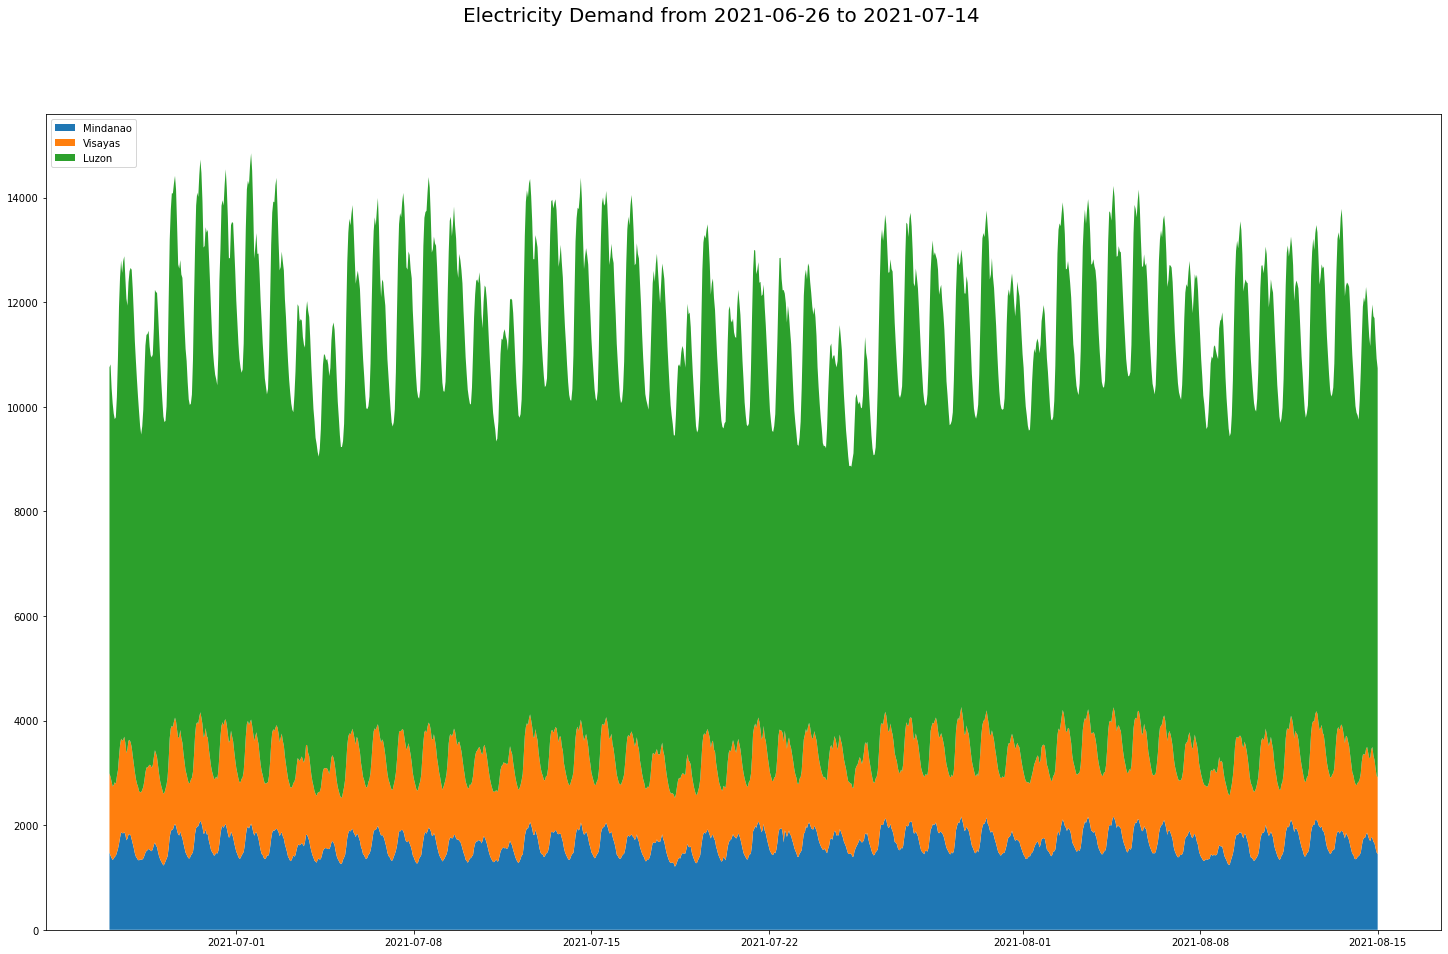

In [90]:
fig, ax = plt.subplots(figsize=(25,15))
plt.stackplot(df_min_hr.index, df_min_hr.MKT_REQT, df_vis_hr.MKT_REQT, df_luz_hr.MKT_REQT, labels=['Mindanao','Visayas','Luzon'])
plt.legend(loc='upper left')
fig.suptitle(f'Electricity Demand from {start} to {end}', size=20)

In [84]:
df_luz_hr.index

DatetimeIndex(['2021-06-26 00:00:00', '2021-06-26 01:00:00',
               '2021-06-26 02:00:00', '2021-06-26 03:00:00',
               '2021-06-26 04:00:00', '2021-06-26 05:00:00',
               '2021-06-26 06:00:00', '2021-06-26 07:00:00',
               '2021-06-26 08:00:00', '2021-06-26 09:00:00',
               ...
               '2021-08-14 15:00:00', '2021-08-14 16:00:00',
               '2021-08-14 17:00:00', '2021-08-14 18:00:00',
               '2021-08-14 19:00:00', '2021-08-14 20:00:00',
               '2021-08-14 21:00:00', '2021-08-14 22:00:00',
               '2021-08-14 23:00:00', '2021-08-15 00:00:00'],
              dtype='datetime64[ns]', name='TIME_INTERVAL', length=1201, freq='H')

### Series plot

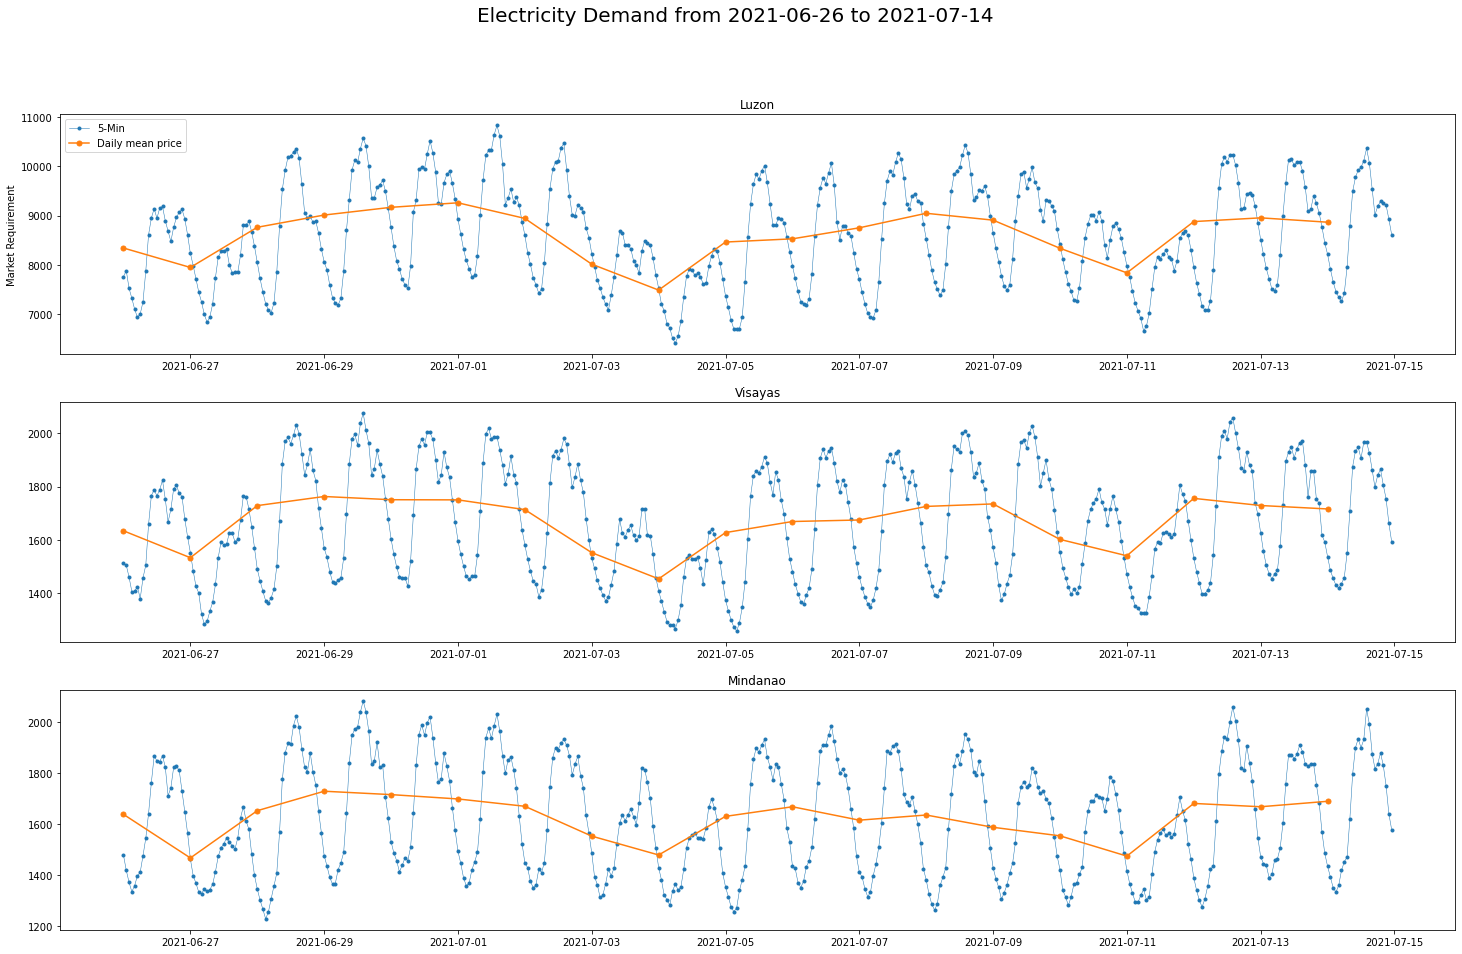

In [91]:
import matplotlib.pyplot as plt

start, end = '2021-06-26', '2021-07-14'

fig, ax = plt.subplots(3,1, figsize=(25,15))

ax[0].plot(df_luz_hr.loc[start:end, 'MKT_REQT'], marker='.', linestyle='-', linewidth=0.5, label='5-Min')
ax[0].plot(df_luz_day.loc[start:end, 'MKT_REQT'], marker='o', markersize=5, linestyle='-', label = 'Daily mean price')
ax[0].set_title('Luzon')

ax[1].plot(df_vis_hr.loc[start:end, 'MKT_REQT'], marker='.', linestyle='-', linewidth=0.5, label='5-Min')
ax[1].plot(df_vis_day.loc[start:end, 'MKT_REQT'], marker='o', markersize=5, linestyle='-', label = 'Daily mean price')
ax[1].set_title('Visayas')

ax[2].plot(df_min_hr.loc[start:end, 'MKT_REQT'], marker='.', linestyle='-', linewidth=0.5, label='5-Min')
ax[2].plot(df_min_day.loc[start:end, 'MKT_REQT'], marker='o', markersize=5, linestyle='-', label = 'Daily mean price')
ax[2].set_title('Mindanao')


ax[0].set_ylabel('Market Requirement')
fig.suptitle(f'Electricity Demand from {start} to {end}', size=20)

ax[0].legend()